<a href="https://colab.research.google.com/github/bbaranao/CASO_LATAM/blob/main/CASO_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) ¿Cómo se distribuyen los datos? ¿Conclusiones?

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns 

#df = pd.read_csv("dataset_SCL.csv")
df_dist = pd.read_csv("dataset_SCL.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [145]:
print(df_dist.dtypes)

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object


In [144]:
from scipy import stats

columnas_numericas = df_dist.select_dtypes(['int', 'float']).columns
for num_col in columnas_numericas:
    _, pval = stats.normaltest(df_dist[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))


Columna DIA no sigue una distribución normal
Columna MES no sigue una distribución normal
Columna AÑO no sigue una distribución normal


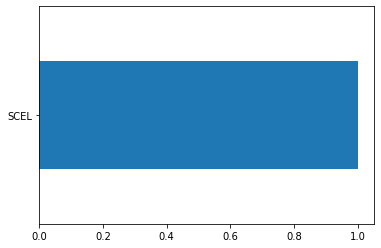

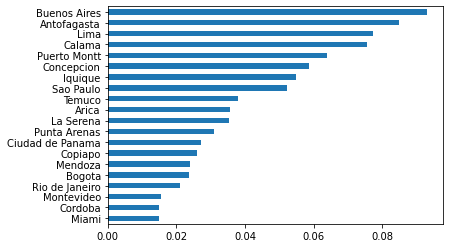

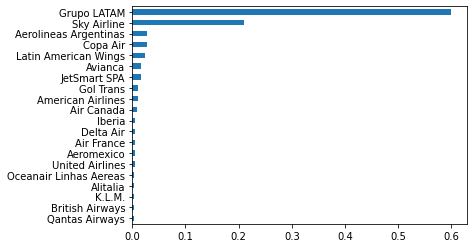

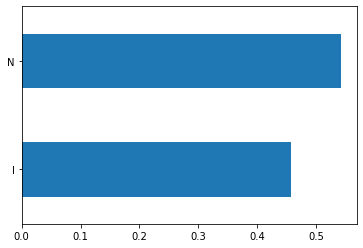

In [152]:
def distribucion_variable_categorica(col):
    df_dist[col].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
    plt.show()

distribucion_variable_categorica("Ori-I")
distribucion_variable_categorica("SIGLADES") 
distribucion_variable_categorica("OPERA")
distribucion_variable_categorica("TIPOVUELO")


In [2]:

df["Fecha-I"] = pd.to_datetime(df['Fecha-I'], format = "%Y%m%d %H:%M:%S")
df["Fecha-O"] = pd.to_datetime(df['Fecha-O'], format = "%Y%m%d %H:%M:%S")


# 2 Genera las columnas adicionales 
synthetic_features.csv :

1) temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.

2) dif_min : diferencia en minutos entre Fecha-O y Fecha-I .

3) atraso_15 : 1 si dif_min > 15, 0 si no.

4) periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I .

In [3]:
#temporada alta
from datetime import date 

df['year-I'] = pd.DatetimeIndex(df['Fecha-I']).year
df['month-I'] = pd.DatetimeIndex(df['Fecha-I']).month
df['day-I'] = pd.DatetimeIndex(df['Fecha-I']).day




In [4]:
import datetime 

d1 = datetime.datetime(2018, 12, 15)
d2 = datetime.datetime(2018, 3, 3)
d3 = datetime.datetime(2018, 7, 15)
d4 = datetime.datetime(2018, 7, 31)
d5 = datetime.datetime(2018, 9, 11)
d6 = datetime.datetime(2018, 9, 30)

df["temporada_alta"] = ( ((df["month-I"] > d1.month) & (df["day-I"] > d1.day)) | 
                         ((df['month-I'] < d2.month) & (df["day-I"] < d2.day)) |
                         ((df["month-I"] > d3.month) & (df["day-I"] > d3.day)) |
                         ((df['month-I'] < d4.month) & (df["day-I"] < d4.day)) |
                         ((df["month-I"] > d5.month) & (df["day-I"] > d5.day)) |
                         ((df['month-I'] < d6.month) & (df["day-I"] < d6.day)) ).astype(int)



In [5]:
##dif_min : diferencia en minutos entre Fecha-O y Fecha-I .

import datetime 

df["dif_min"] = df["Fecha-O"] - df["Fecha-I"]
df["dif_min"] = df["dif_min"] / np.timedelta64(1, "m")



In [6]:
##atraso_15 : 1 si dif_min > 15, 0 si no.

df["atraso_15"] = (df["dif_min"] > 15).astype(int)


In [7]:
##periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .

##5:00 <= a <= 11:59 ## mañana 
##12:00 <= b <= 18:59
#19:00 <= b <= 4:59

df['hour-I'] = pd.DatetimeIndex(df['Fecha-I']).hour

def periodo_dia (hora):
  return ( "mañana"
  if 5 <= hora <= 11
  else "tarde"
  if 12<= hora <= 18 
  else "noche")

df["periodo_dia"] = df['hour-I'].apply(periodo_dia)
df["periodo_dia"]

0        noche
1        noche
2        noche
3        noche
4        noche
         ...  
68201    tarde
68202    tarde
68203    tarde
68204    tarde
68205    tarde
Name: periodo_dia, Length: 68206, dtype: object

# 3 ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?
R: Dentro de las variables que deberían influir en el atraso de un vuelo son la cantidad de vuelos que hay en un momento N. Dado que esto implicaría más gente en el aeropuerto, lo que podría finamente atrasar los procesos y de la misma forma las pistas de los aviones. 
De la misma manera en mi opinión el destino de el avión podría afectar dado un posible patrón en la cantidad de maletas que llevan los pasajeros en los aviones
Otra variable es la misma aerolínea, esto dependerá de las capacidades de logística y asumo que tienen diferentes presupuestos que podrían afectar su logística de salida o relaciones con aeropuerto. 
Finalmente la temproada alta podría de cierta manera afectar pero debiese estar correlacionado con la cantidad de vuelos que despegan en el moemento N. 

In [8]:
import datetime 
times = [] 

for i in np.arange(len(df)):
  times.append(datetime.datetime(year = df.loc[i, "year-I"], month = df.loc[i, "month-I"], day = df.loc[i, "day-I"]))

In [9]:
df["Dia-I"] = times

In [10]:
data = df.groupby(by = ["Des-I","Emp-I","month-I", "day-I", "temporada_alta", "TIPOVUELO"], as_index = True)["dif_min"].agg(["mean","count","min", "max"])
data


mean  count   min   max
Des-I Emp-I month-I day-I temporada_alta TIPOVUELO                         
CYYZ  ACA   1       1     1              I          20.0      1  20.0  20.0
                    2     1              I          17.0      1  17.0  17.0
                    3     1              I          19.0      1  19.0  19.0
                    4     1              I          47.0      1  47.0  47.0
                    5     1              I           5.0      1   5.0   5.0
...                                                  ...    ...   ...   ...
YSSY  QFU   12      26    1              I          46.0      1  46.0  46.0
                    27    1              I          39.0      1  39.0  39.0
                    29    1              I          19.0      1  19.0  19.0
                    30    1              I          24.0      1  24.0  24.0
                    31    1              I          -1.0      1  -1.0  -1.0

[26371 rows x 4 columns]

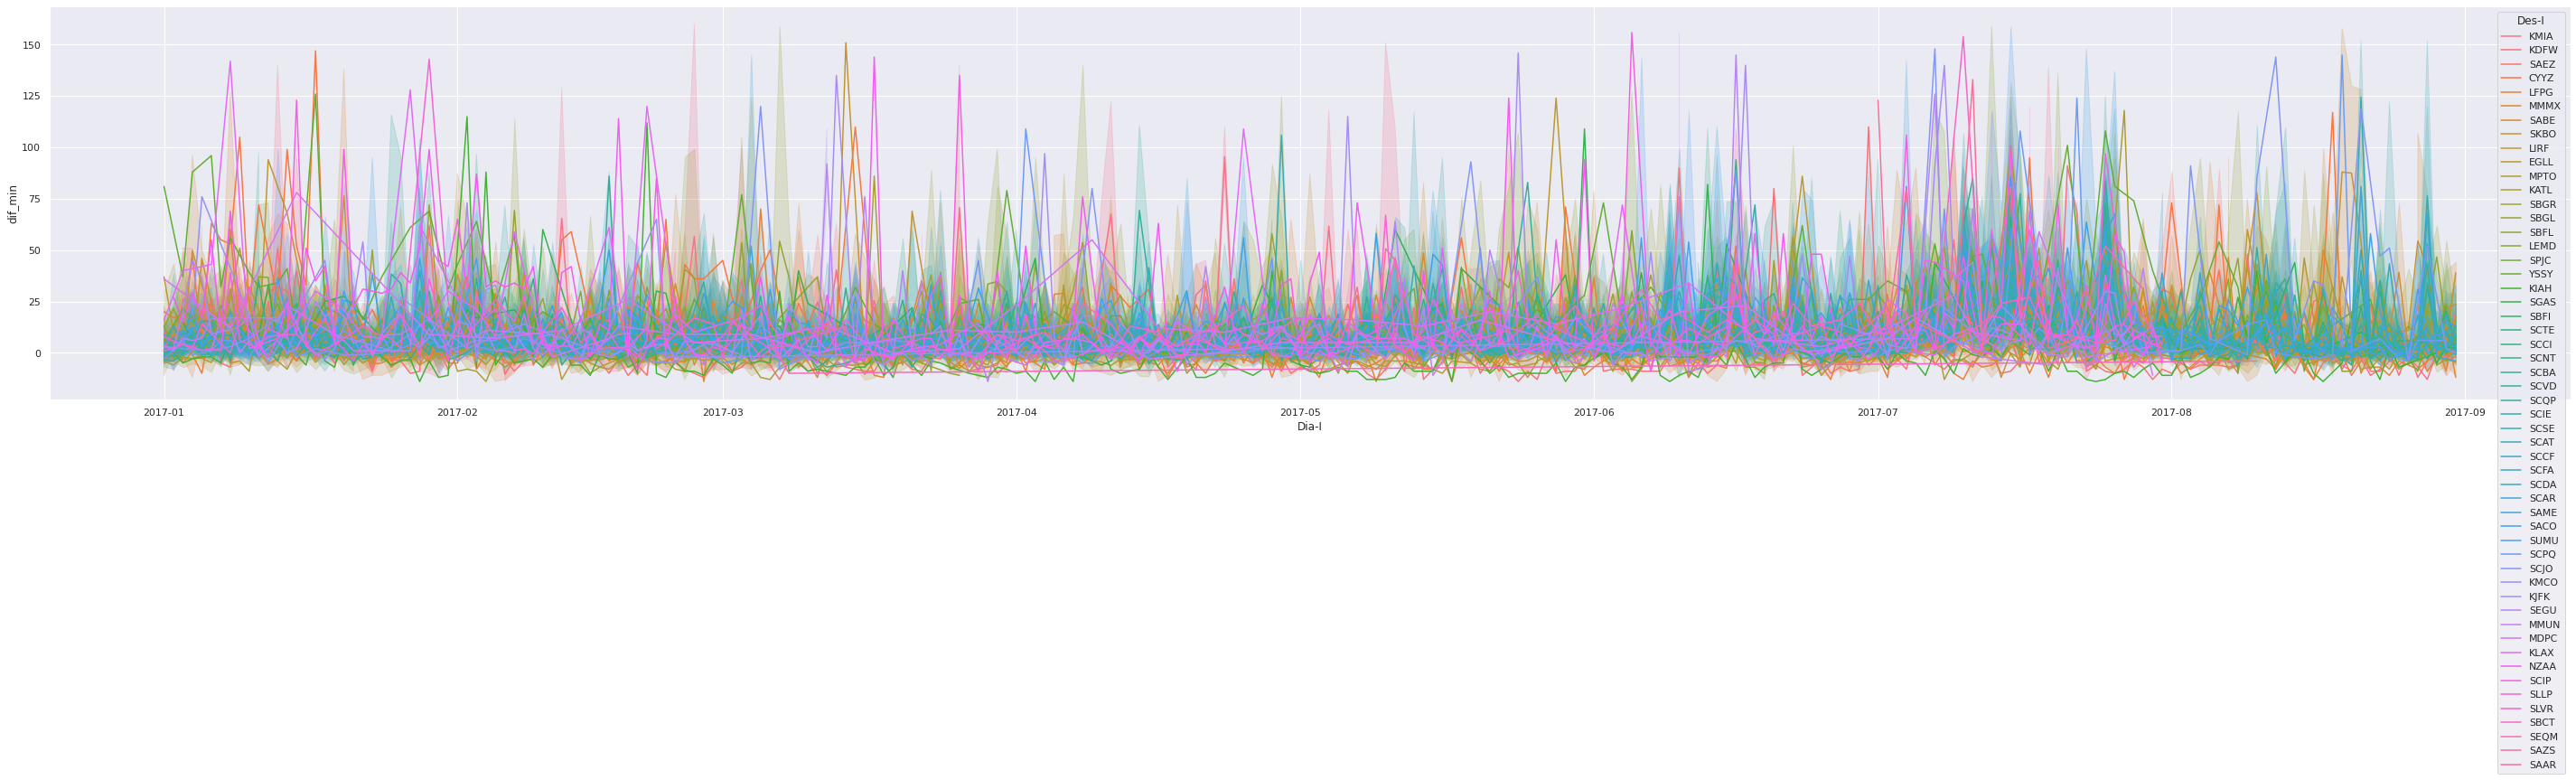

In [41]:
sns.lineplot(x= "Dia-I", y = "dif_min", hue = "Des-I", data = df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


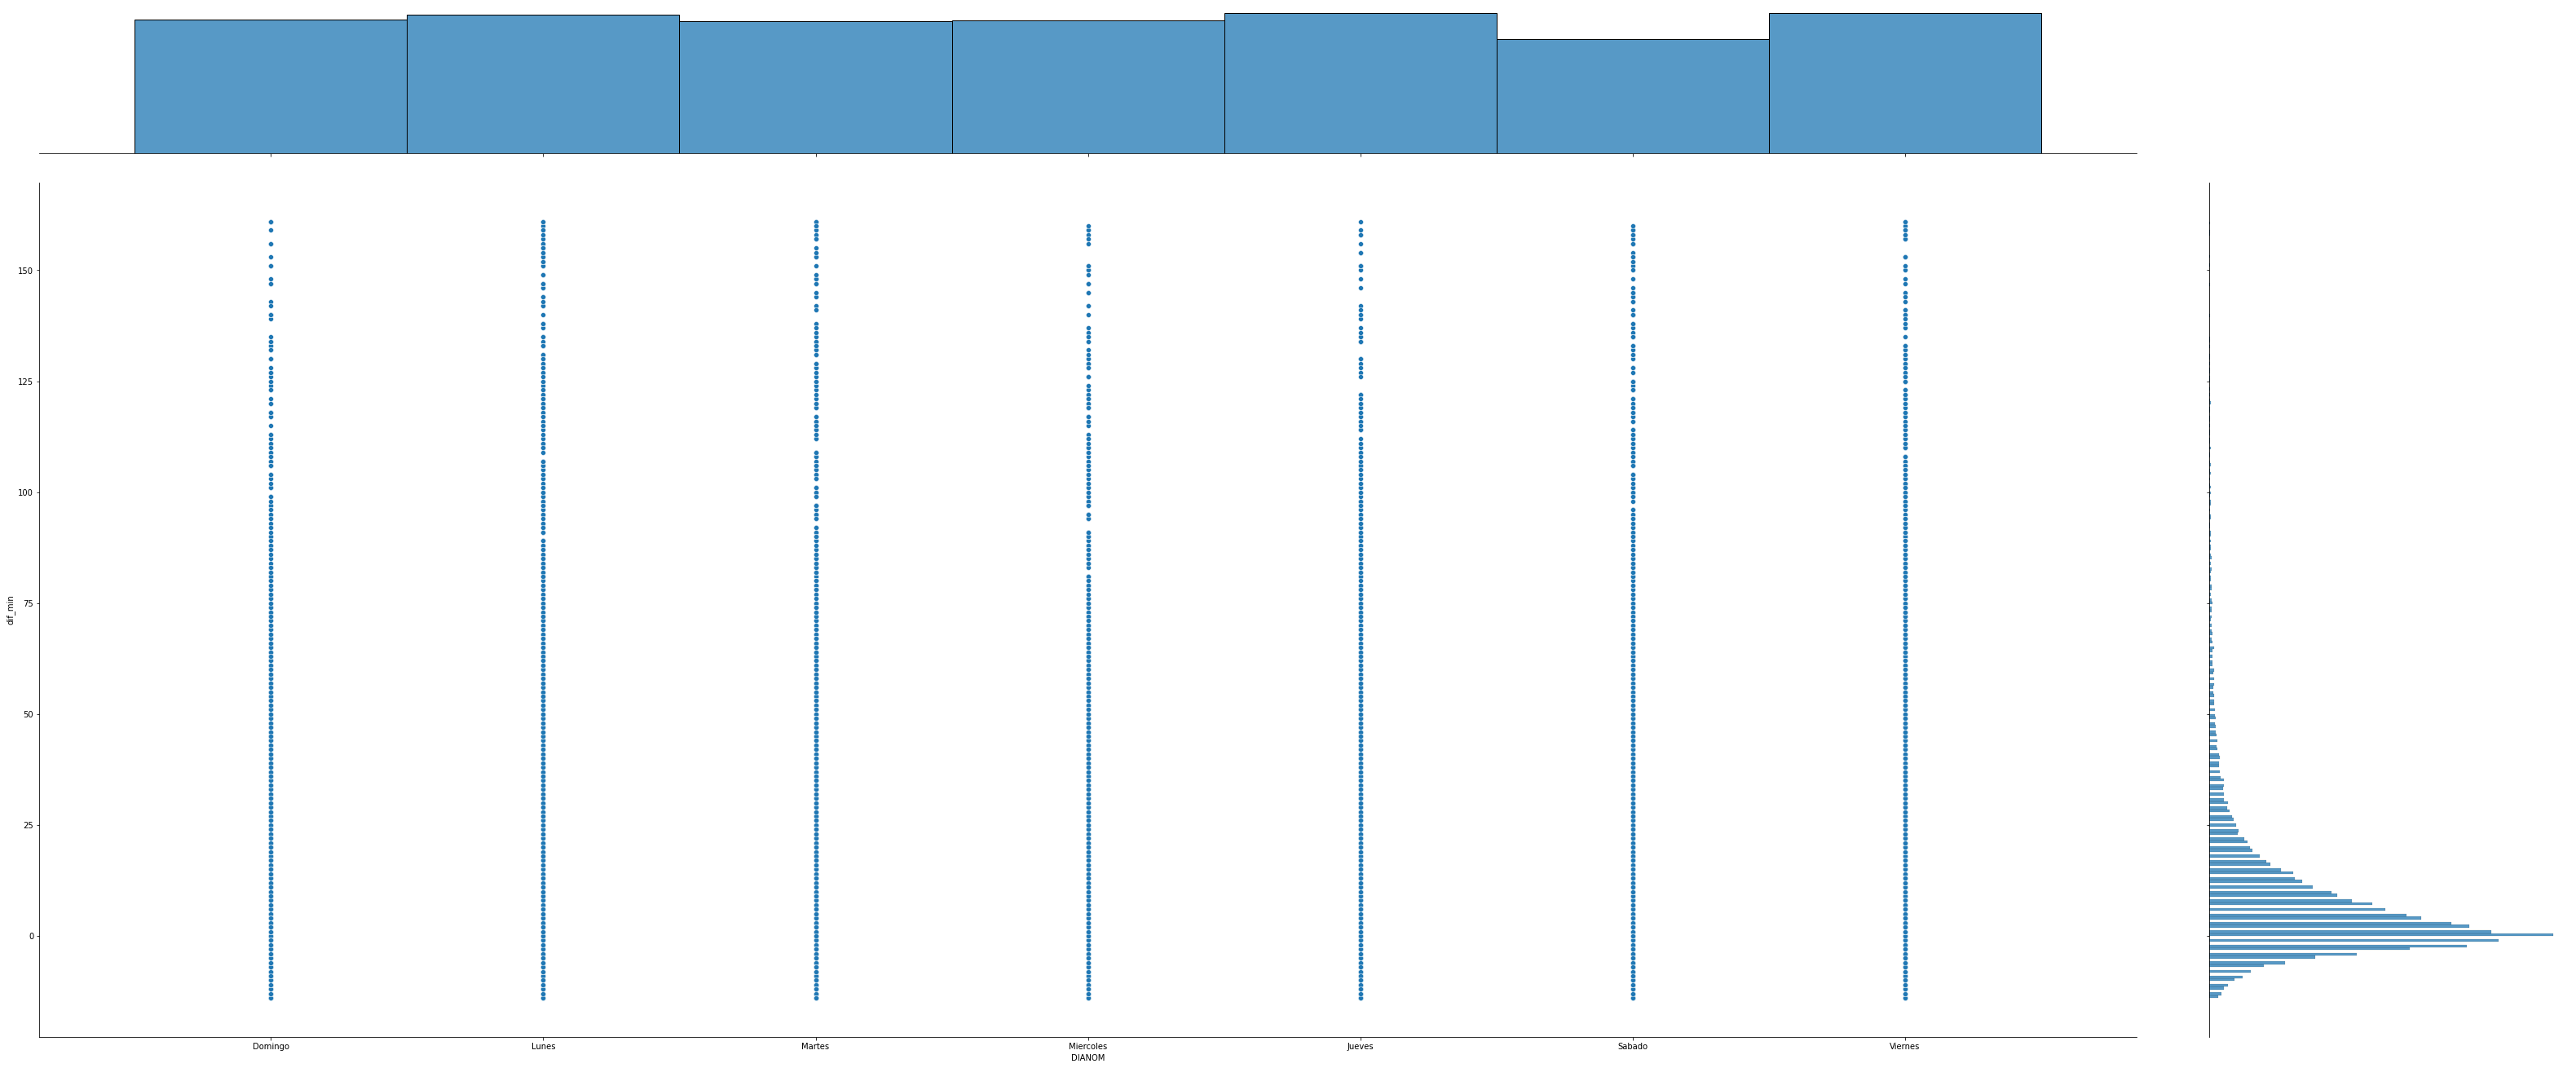

In [54]:
graph2 = sns.jointplot(df['DIANOM'], df["dif_min"])
graph2.fig.set_figwidth(50)
graph2.fig.set_figheight(20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 576x288 with 0 Axes>

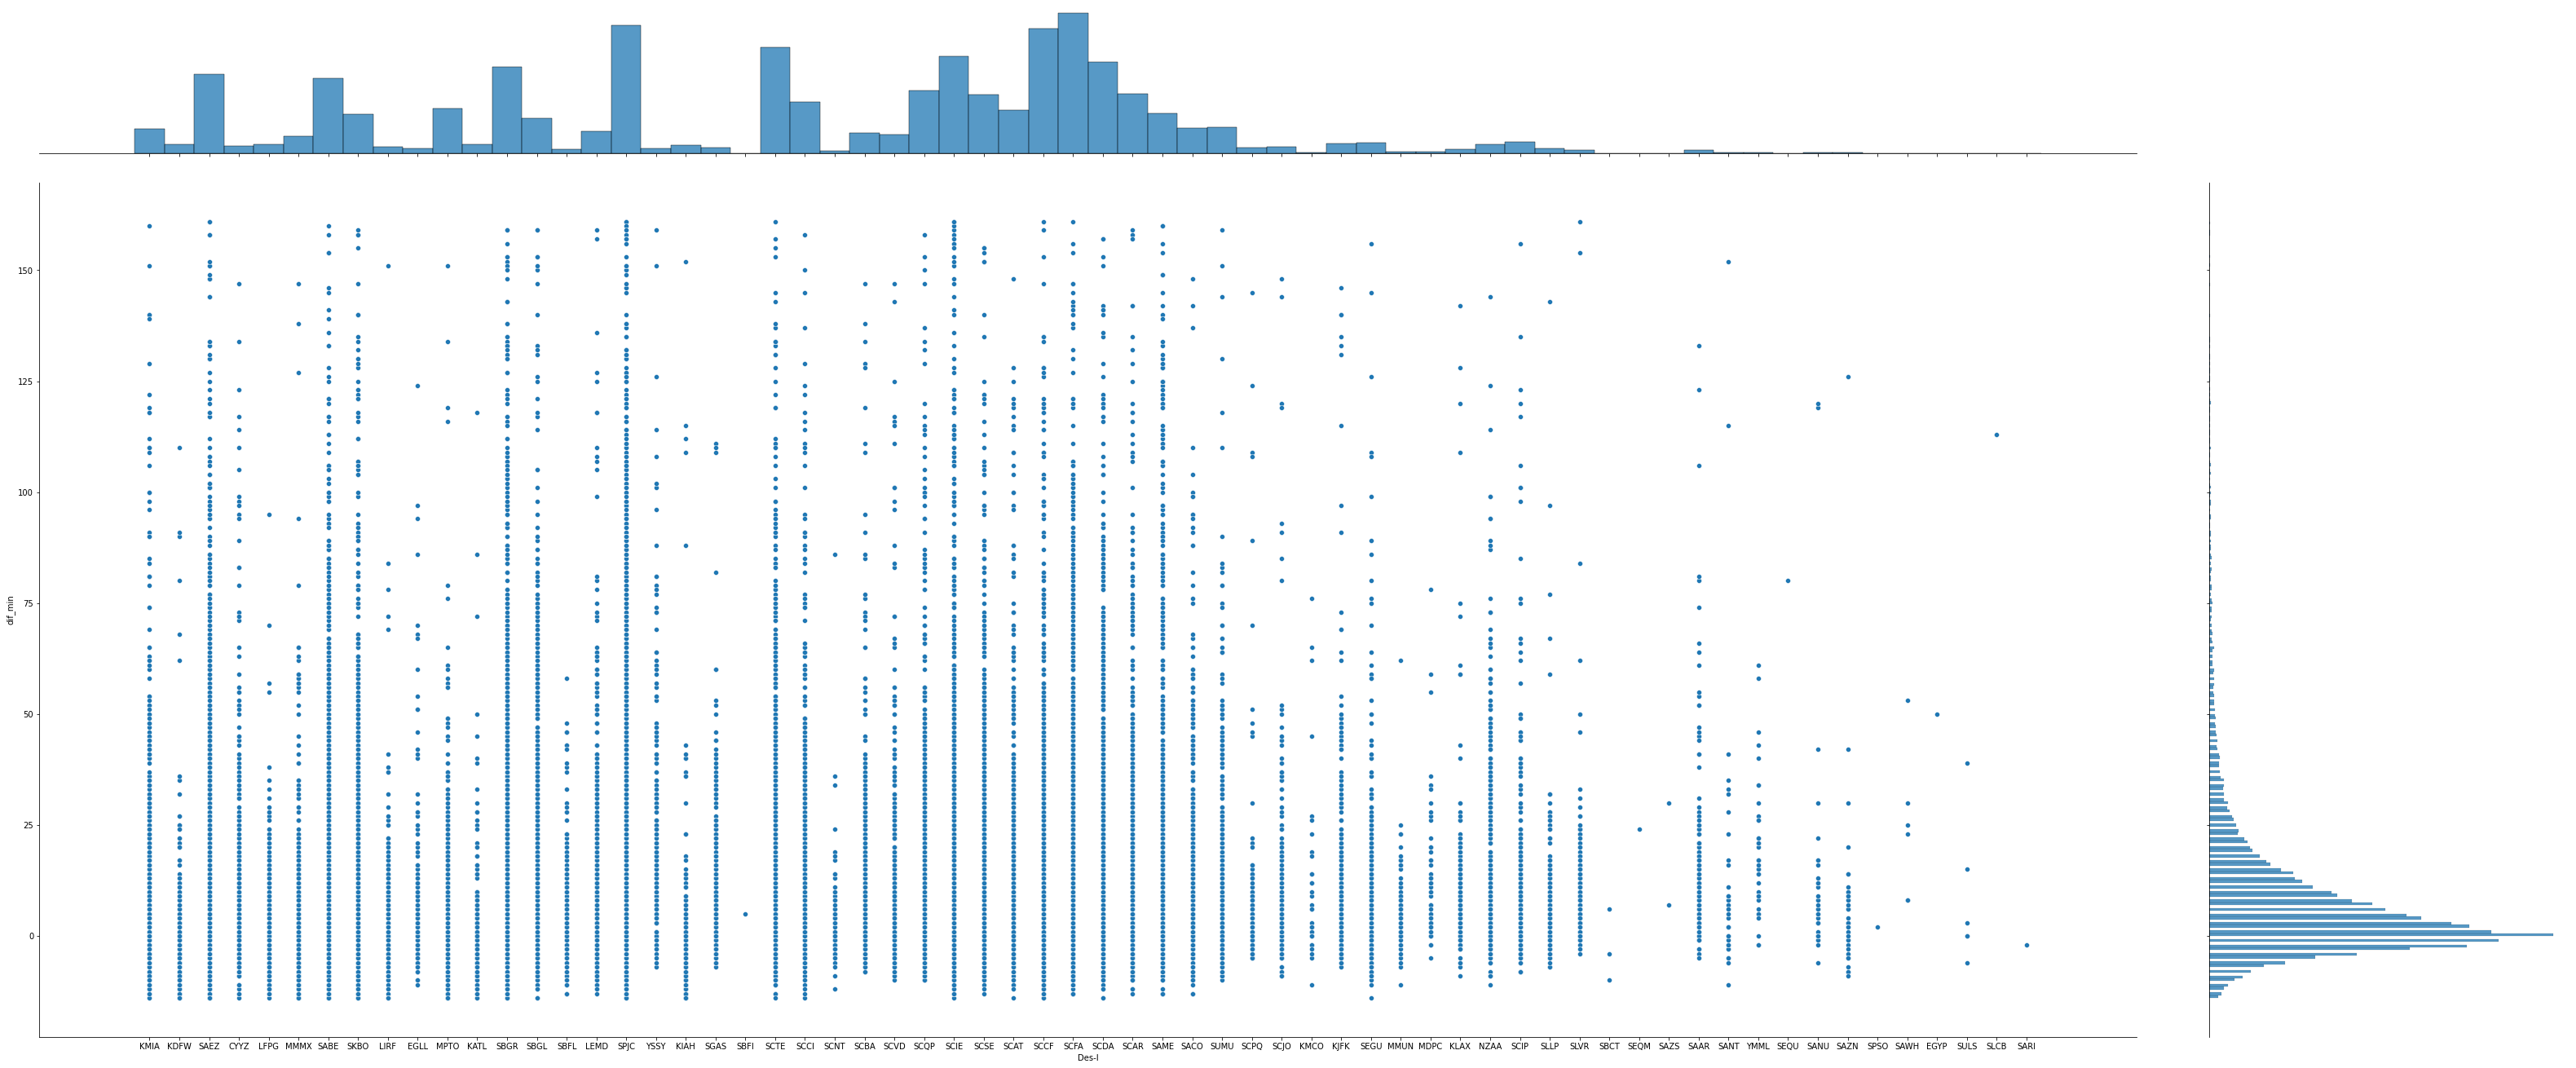

In [53]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,4))
graph3 = sns.jointplot(df['Des-I'], df["dif_min"])
graph3.fig.set_figwidth(50)
graph3.fig.set_figheight(20)




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


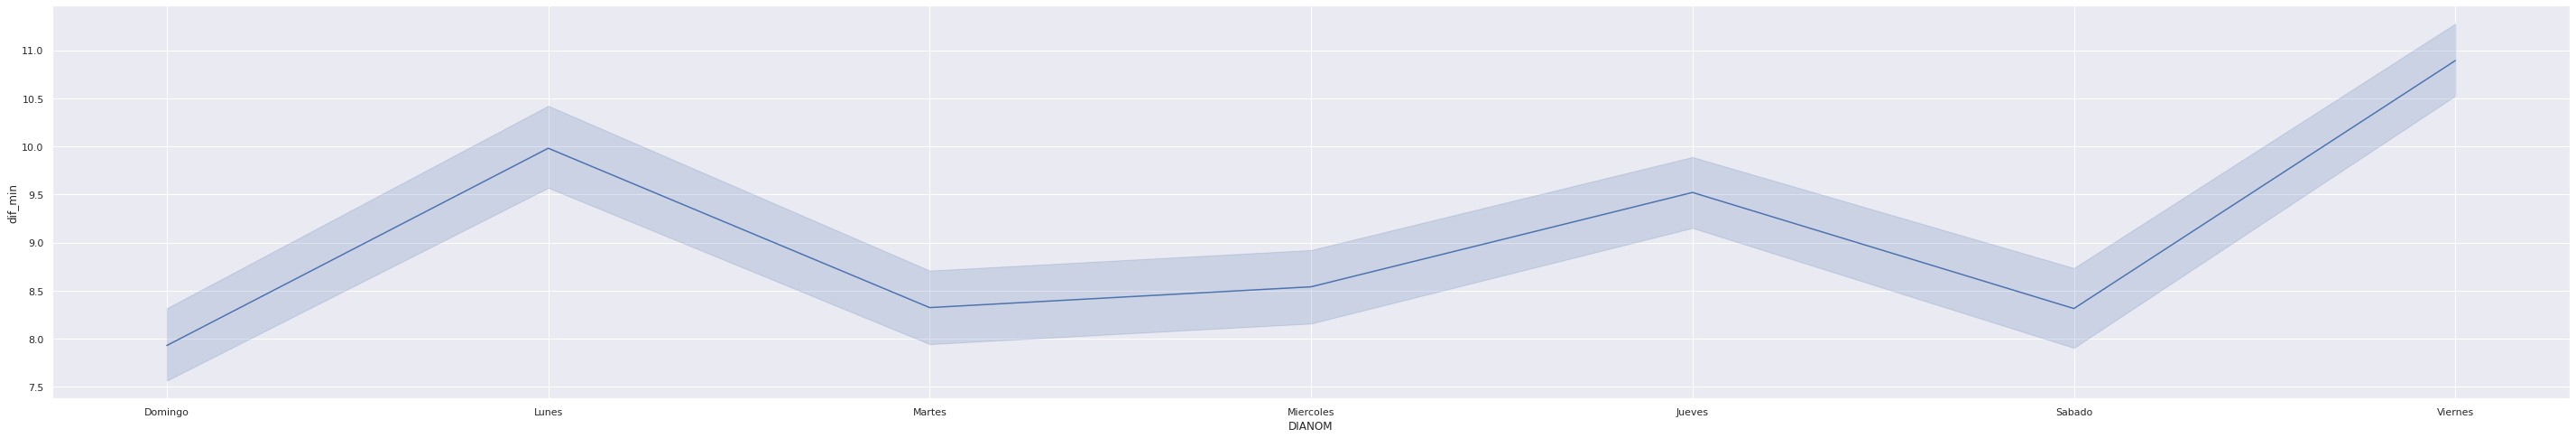

In [58]:
sns.lineplot(df['DIANOM'], df["dif_min"])

In [61]:
gb1 = pd.DataFrame(df.groupby(["Des-I", "month-I"], as_index=False)["dif_min"].mean())

In [62]:
data = gb1.pivot("month-I", "Des-I", "dif_min")

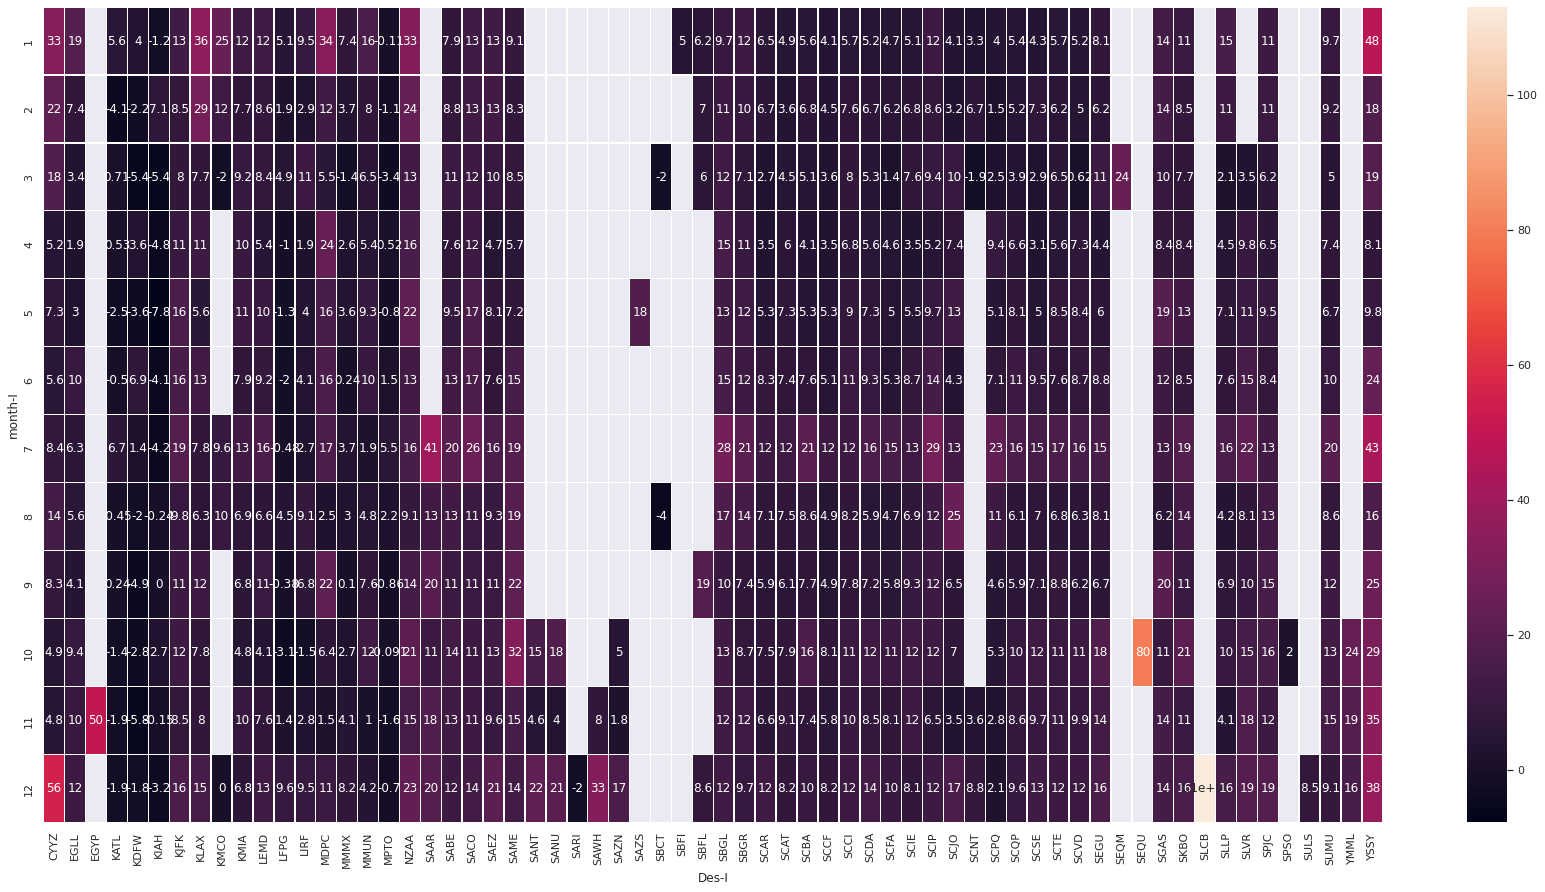

In [64]:
sns.set(rc={"figure.figsize": (30,15)})
sns.heatmap(data = data, annot = True, linewidths =.5)

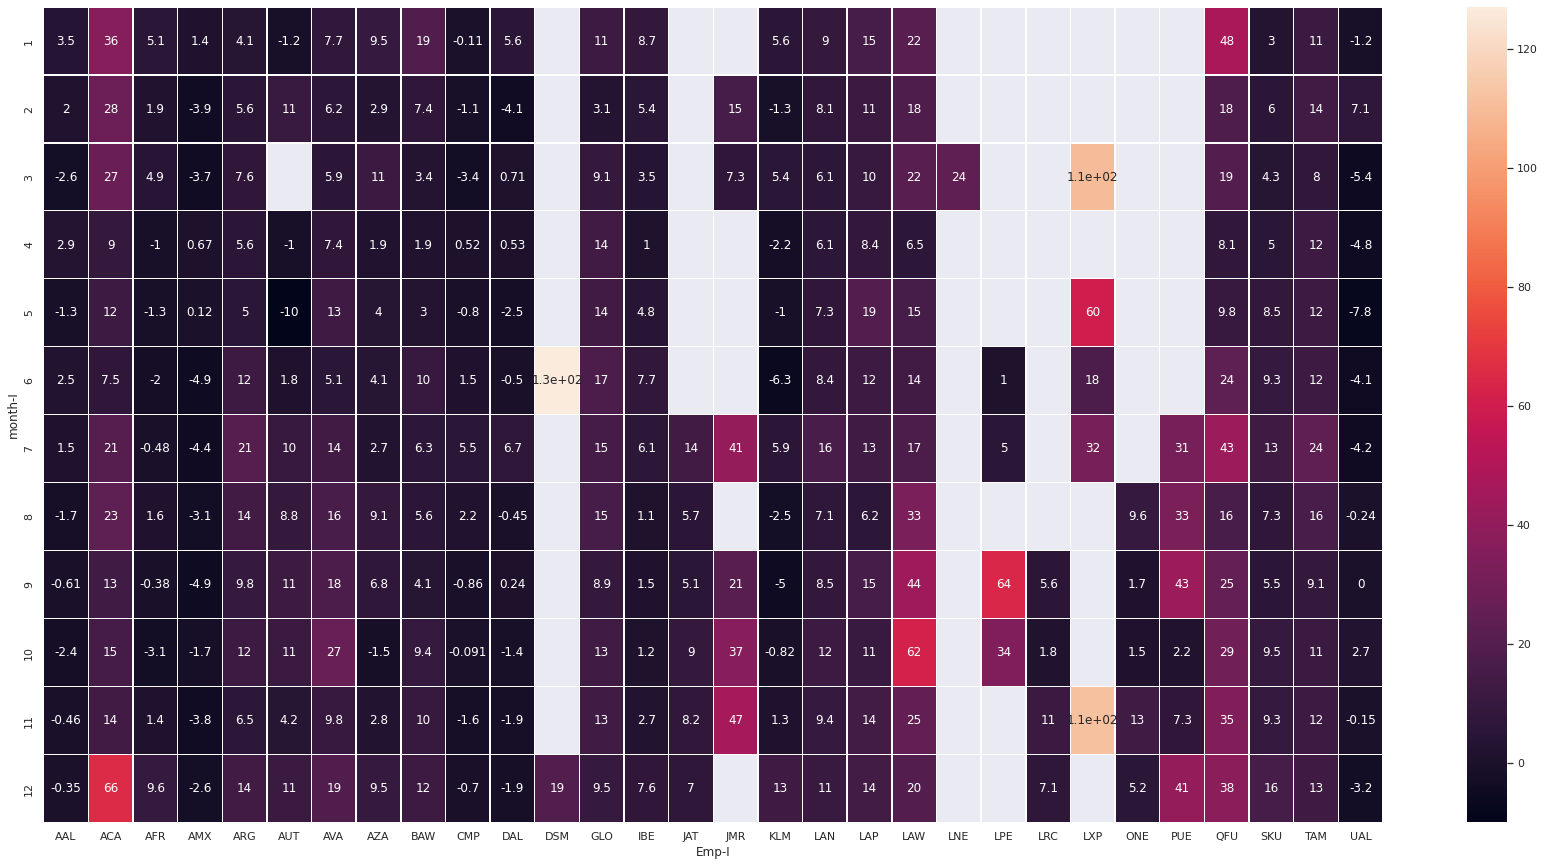

In [67]:
gb2 = pd.DataFrame(df.groupby(["Emp-I", "month-I"], as_index=False)["dif_min"].mean())
data2 = gb2.pivot("month-I", "Emp-I", "dif_min")
sns.set(rc={"figure.figsize": (30,15)})
sns.heatmap(data = data2, annot = True, linewidths =.5)

# 4) Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [11]:

data2 = df.groupby(by = ["DIANOM","hour-I"], as_index = False).agg(DELAY = ("atraso_15","sum"), TOTAL = ("atraso_15","count"))
data2

,DIANOM,hour-I,DELAY,TOTAL
0,Domingo,0,53,141
1,Domingo,1,33,192
2,Domingo,2,12,44
3,Domingo,3,9,80
4,Domingo,4,4,89
...,...,...,...,...
163,Viernes,19,143,555
164,Viernes,20,125,470
165,Viernes,21,119,415
166,Viernes,22,98,375


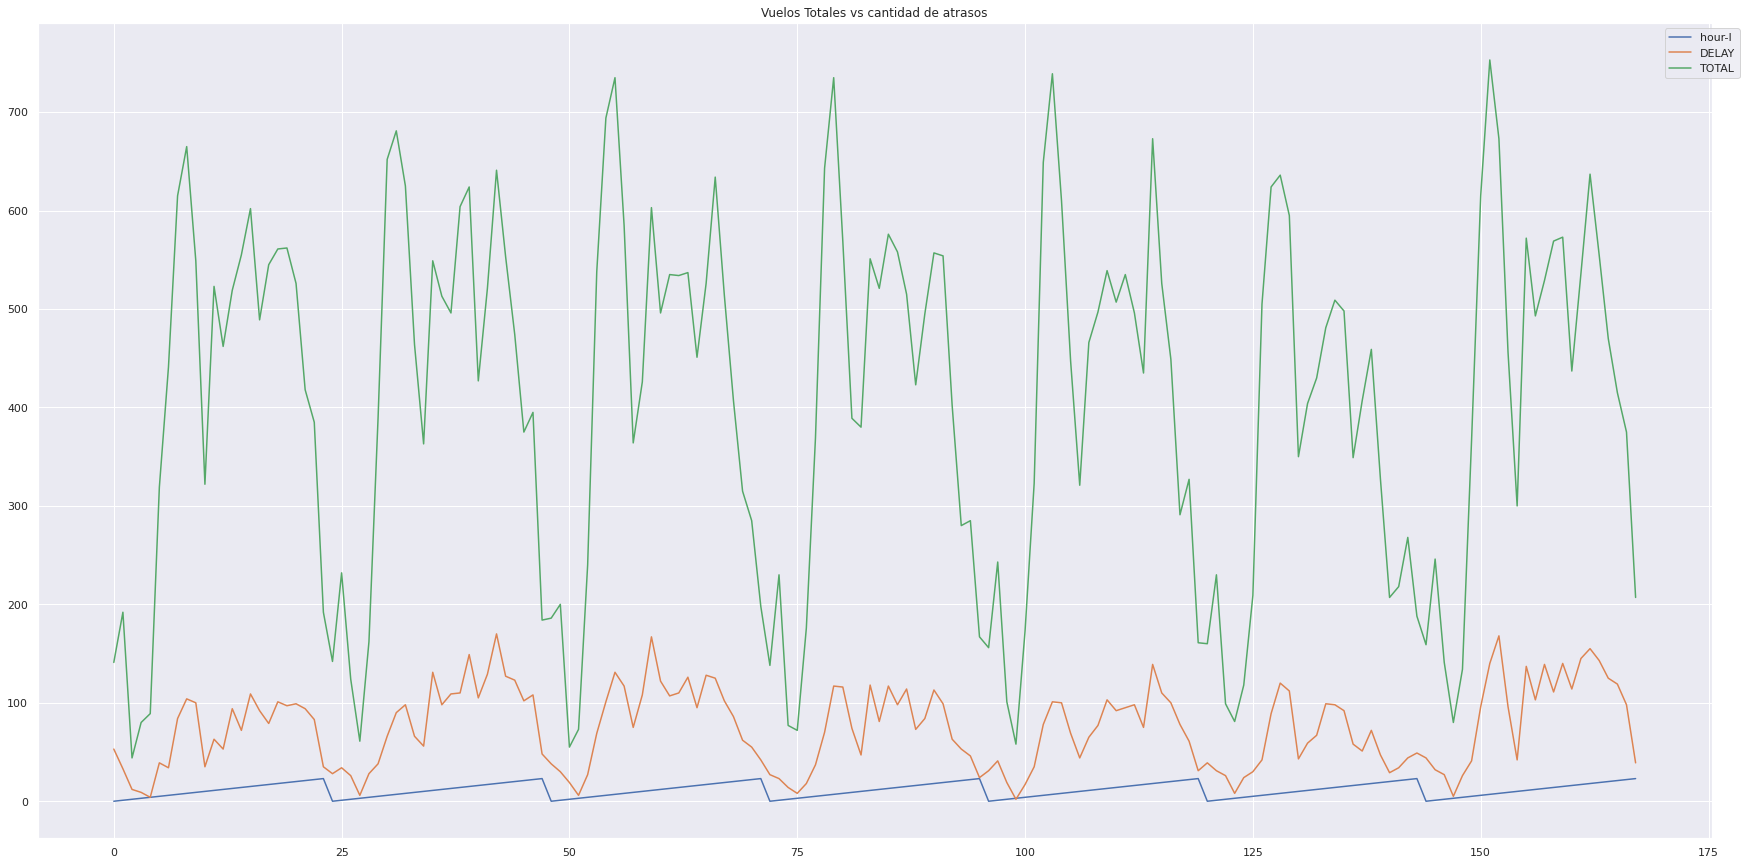

In [99]:
data2.plot(kind='line', title="Vuelos Totales vs cantidad de atrasos").legend(bbox_to_anchor= (1.02, 1));

In [12]:
data3 = df.groupby(by = ["OPERA"], as_index = False).agg(DELAY = ("atraso_15","sum"), TOTAL = ("atraso_15","count"))
data3["% DELAY"] = data3["DELAY"]/data3["TOTAL"]
data3

,OPERA,DELAY,TOTAL,% DELAY
0,Aerolineas Argentinas,468,1949,0.240123
1,Aeromexico,10,351,0.028490
2,Air Canada,258,565,0.456637
3,Air France,30,358,0.083799
4,Alitalia,29,259,0.111969
5,American Airlines,51,757,0.067371
6,Austral,15,74,0.202703
7,Avianca,306,1152,0.265625
8,British Airways,29,205,0.141463
9,Copa Air,116,1850,0.062703


In [121]:
sns.scatterplot(data= data3, x = "TOTAL", y = "DELAY", 
                size = "% DELAY", hue = "OPERA", legend = True, s = 5000)

for i in range(data3.shape[0]):
 plt.text(x=data3.TOTAL[i]+0.3,y=data3.DELAY[i]+0.3,s=data3.OPERA[i])

plt.xlim(0, 5000)
plt.ylim(0, 1000)



##sns.scatterplot(data=data3,x="TOTAL",y="DELAY")

##for i in range(data3.shape[0]):
 ##plt.text(x=data3.TOTAL[i]+0.3,y=data3.DELAY[i]+0.3,s=data3.OPERA[i])

(0.0, 1000.0)

In [128]:
#Regresión Logística 

import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

data3 = df.groupby(by = ["OPERA"], as_index = False).agg(DELAY = ("atraso_15","sum"), TOTAL = ("atraso_15","count"))
df["TOTAL"] = data3["TOTAL"]
df["DELAY"] = data3["DELAY"]


data_reg = df[["TOTAL", "dif_min"]]
dummies = pd.get_dummies(data = df[["OPERA", "DIANOM","periodo_dia"]])

data_reg = pd.concat([dummies,data_reg], axis = 1)
data_reg["TIPOVUELO"] = (df["TIPOVUELO"] == "I").astype(int)
data_reg['TOTAL'] = data_reg['TOTAL'].fillna(0).astype(int)
data_reg['dif_min'] = data_reg['dif_min'].fillna(0).astype(int)

In [129]:
X = data_reg
X = X.drop(["dif_min"], axis=1) 
y = data_reg["dif_min"] < 15


In [130]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,train_size=0.7)


In [131]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train= min_max_scaler.fit_transform(X_train)

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [133]:
np.round(logreg.predict_proba(X_test),3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.243, 0.757],
       [0.199, 0.801],
       [0.185, 0.815],
       ...,
       [0.147, 0.853],
       [0.206, 0.794],
       [0.148, 0.852]])

In [118]:
print('Accuracy: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy: 0.80


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [119]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  315 10641]
 [  277 43332]]


# 5)Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

R: El algoritmo tiene un 80% de accuracy, escogí un modelo ede regtresión logística principalmetne por que trabaja con probabilidades y se buscaba predecit la probabilidad que un avbión se atrase. Eso si considere que el atraso se contaría desde el minuto 15 para dar un margen de error principalmente. Para mejorar el performance se podría hacer combinaciones de dataframes y probar otras formas de preprocessing de sklearn. 